# AIDP 機械学習のサンプルコード
オブジェクトストレージ上のCSV(wine_data.csv)ファイルを読み込み、機械学習を実行するサンプルコードです。
wine_data.csvのカタログを収集済の状態で実行します。

In [ ]:
%sql
select * from object_storage.default.wine_data_table


In [1]:
%sql
SELECT class_label, alcohol, color_intensity
FROM object_storage.default.wine_data_table
WHERE alcohol > 13.0
ORDER BY color_intensity DESC
LIMIT 10

In [ ]:
# wine_data.csv を学習データとした機械学習の処理(SparkML)

# 全件取得（Spark SQL）
wine_data = spark.sql("SELECT * FROM object_storage.default.wine_data_table")

# 最初の 5 行だけ表示
wine_data.show(5, truncate=False)

+-----------+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+
|class_label|alcohol|malic_acid|ash |alcalinity_of_ash|magnesium|total_phenols|flavanoids|nonflavanoid_phenols|proanthocyanins|color_intensity|hue |od280_od315_of_diluted_wines|proline|
+-----------+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+
|1          |14.23  |1.71      |2.43|15.6             |127      |2.8          |3.06      |0.28                |2.29           |5.64           |1.04|3.92                        |NULL   |
|1          |13.2   |1.78      |2.14|11.2             |100      |2.65         |2.76      |0.26                |1.28           |4.38           |1.05|3.4                         |NULL   |
|1          |13.16  |2.36      |2.67|18.6             |101      |2.8  

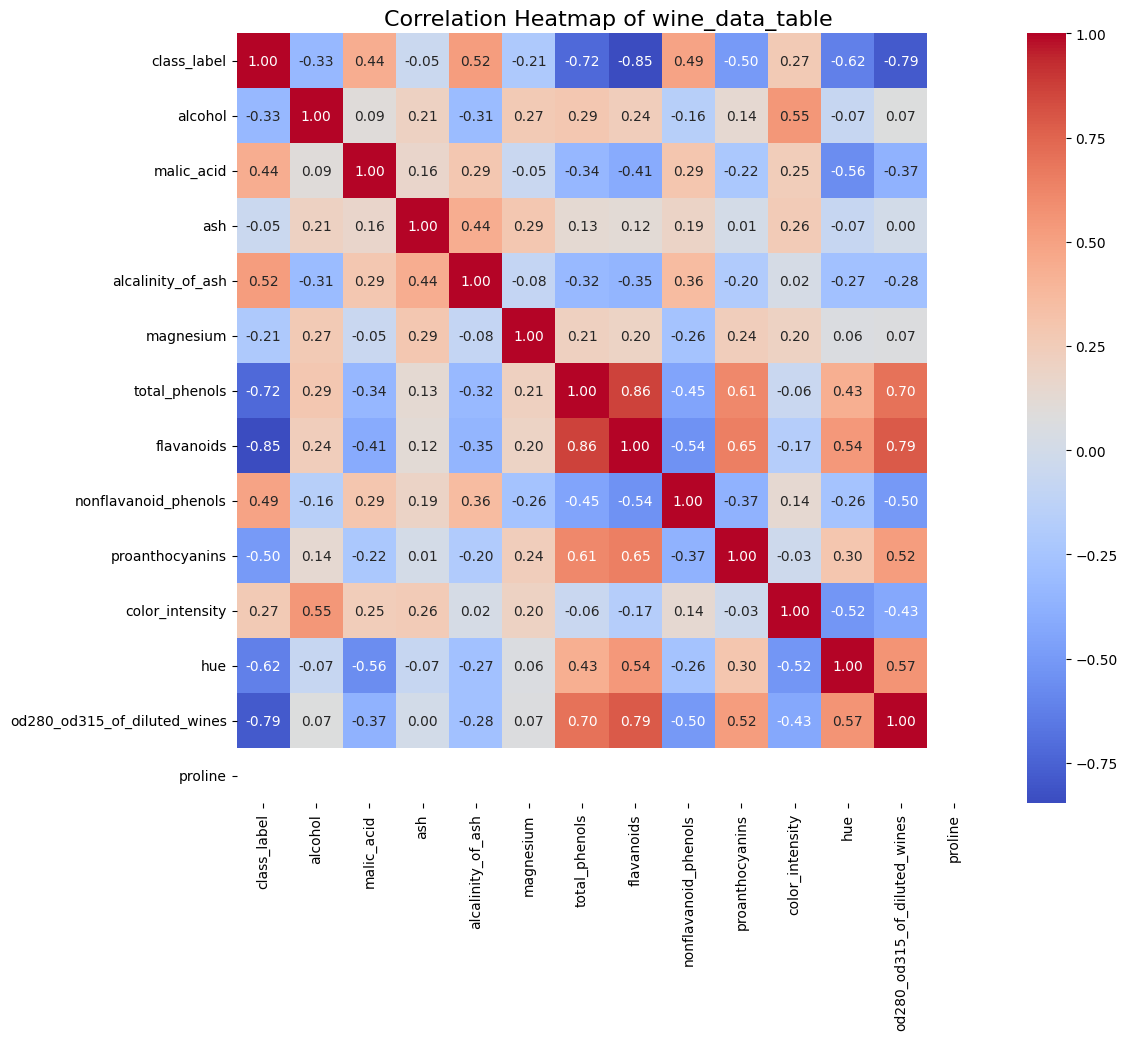

In [1]:
# EDA(探索的データ分析)を実行
# 事前にseabornとmatplotlibをSpark Clusterにインストール
# https://docs.oracle.com/en/cloud/paas/ai-data-platform/aidug/manage-libraries.html

import seaborn as sns
import matplotlib.pyplot as plt

# Spark DataFrame を Pandas に変換
pdf = wine_data.toPandas()

# 数値列の相関行列を計算
corr = pdf.corr(numeric_only=True)

# ヒートマップを描画
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of wine_data_table", fontsize=16)
plt.show()

In [1]:
# 機械学習モデルの構築

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# 説明変数
feature_cols = ["flavanoids", "od280_od315_of_diluted_wines", "total_phenols"]

# VectorAssembler で特徴量をまとめる
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# 決定木分類器を定義
dt = DecisionTreeClassifier(labelCol="class_label", featuresCol="features")

# パイプラインに組み込む
pipeline = Pipeline(stages=[assembler, dt])

# データを学習用とテスト用に分割
train_df, test_df = wine_data.randomSplit([0.8, 0.2], seed=42)

# モデル学習
model = pipeline.fit(train_df)

In [1]:
# サンプルデータを定義して推論を実行

from pyspark.sql import Row
from pyspark.sql import SparkSession

# Spark セッションがない場合は作成
spark = SparkSession.builder.getOrCreate()

# 予測用サンプルデータを作成
sample_data = [
    Row(flavanoids=2.5, od280_od315_of_diluted_wines=3.0, total_phenols=1.8)
]

sample_df = spark.createDataFrame(sample_data)

# 学習済みモデルで予測
predictions = model.transform(sample_df)

# 結果を表示（サンプル値と予測結果のみ）
predictions.select("flavanoids", "od280_od315_of_diluted_wines", "total_phenols", "prediction").show()

+----------+----------------------------+-------------+----------+
|flavanoids|od280_od315_of_diluted_wines|total_phenols|prediction|
+----------+----------------------------+-------------+----------+
|       2.5|                         3.0|          1.8|       2.0|
+----------+----------------------------+-------------+----------+



In [1]:
# 評価用データでモデルの精度をスコアリング

# 評価用データで推論実行
predictions = model.transform(test_df)

# 精度スコアの算出
evaluator = MulticlassClassificationEvaluator(labelCol="class_label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy = {accuracy:.4f}")

Test Accuracy = 0.7931


In [1]:
predictions.select("class_label", "prediction", *feature_cols).show(10)

+-----------+----------+----------+----------------------------+-------------+
|class_label|prediction|flavanoids|od280_od315_of_diluted_wines|total_phenols|
+-----------+----------+----------+----------------------------+-------------+
|          1|       1.0|      2.43|                        2.51|         2.45|
|          1|       1.0|      2.64|                        2.69|          2.4|
|          1|       1.0|      2.76|                         3.4|         2.65|
|          1|       2.0|      2.19|                        2.77|          2.4|
|          1|       1.0|      3.29|                        3.38|         3.15|
|          1|       1.0|      3.03|                        3.36|          2.7|
|          1|       1.0|      2.76|                         2.9|          2.6|
|          1|       1.0|      3.15|                        3.55|         2.98|
|          1|       2.0|      2.43|                        2.82|          2.2|
|          1|       1.0|      3.93|                 

In [1]:
# predictionのデータをオブジェクトストレージに書き出す

# 事前にexternal volume(Object Storage)を作成

# 評価結果のdfをオブジェクトストレージに書き出し
#predictions.write.mode("overwrite").option("header", True).format("parquet").save(f'/Volumes/object_storage/default/output/predictions')

predictions.write \
    .mode("overwrite") \
    .format("delta") \
    .save('/Volumes/object_storage/default/output/predictions')

In [1]:
# オブジェクトストレージ書き出したparquetを確認
#df_read = spark.read.option("header", True).format("parquet").load(f'/Volumes/object_storage/default/output/predictions')
#df_read.select("class_label", "prediction", *feature_cols).show(10)

df_read = spark.read.format("delta").load(f'/Volumes/object_storage/default/output/predictions')
df_read.show(10, False)

+-----------+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+----------------+-------------------+------------------------------------------------+----------+
|class_label|alcohol|malic_acid|ash |alcalinity_of_ash|magnesium|total_phenols|flavanoids|nonflavanoid_phenols|proanthocyanins|color_intensity|hue |od280_od315_of_diluted_wines|proline|features        |rawPrediction      |probability                                     |prediction|
+-----------+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+----------------+-------------------+------------------------------------------------+----------+
|1          |13.05  |1.65      |2.55|18.0             |98       |2.45         |2.43      |0.29                |1.44           |4.25           |1.12|2.5